In [3]:
!pip install -q efficientnet_pytorch           

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
!pip install --upgrade pip

In [4]:
# System
import cv2
import os, os.path
from PIL import Image              # from RBG to YCbCr
import gc
import time
import datetime

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    # to check images
# %matplotlib inline
from tqdm.notebook import tqdm      # beautiful progression bar

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2, ToTensor

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

import warnings
warnings.filterwarnings("ignore")

In [5]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


In [6]:
# ----- STATICS -----
output_size = 1
# -------------------

In [7]:
# My Train: with imputed missing values + OHE
my_train = pd.read_csv('../input/siim-melanoma-prep-data/train_clean.csv')

# Drop path columns and Diagnosis (it won't be available during TEST)
# We'll rewrite them once the data is concatenated
to_drop = ['path_dicom','path_jpeg', 'diagnosis']
for drop in to_drop:
    if drop in my_train.columns :
        my_train.drop([drop], axis=1, inplace=True)

# Roman's Train: with added data for Malignant category
roman_train = pd.read_csv('../input/../input/melanoma-external-malignant-256/train_concat.csv')


# --- Before concatenatenating both together, let's preprocess roman_train ---
# Replace NAN with 0 for patient_id
roman_train['patient_id'] = roman_train['patient_id'].fillna(0)

# OHE
to_encode = ['sex', 'anatom_site_general_challenge']
encoded_all = []

roman_train[to_encode[0]] = roman_train[to_encode[0]].astype(str)
roman_train[to_encode[1]] = roman_train[to_encode[1]].astype(str)

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(roman_train[column])
    encoded_all.append(encoded)
    
roman_train[to_encode[0]] = encoded_all[0]
roman_train[to_encode[1]] = encoded_all[1]

# Give all columns the same name
roman_train.columns = my_train.columns


# --- Concatenate info which is not available in my_train ---
common_images = my_train['dcm_name'].unique()
new_data = roman_train[~roman_train['dcm_name'].isin(common_images)]

# Merge all together
train_df = pd.concat([my_train, new_data], axis=0)



# --- Read in Test data (also cleaned, imputed, OHE) ---
test_df = pd.read_csv('../input/siim-melanoma-prep-data/test_clean.csv')

# Drop columns
for drop in to_drop:
    if drop in test_df.columns :
        test_df.drop([drop], axis=1, inplace=True)

# Create path column to image folder for both Train and Test
path_train = '../input/melanoma-external-malignant-256/train/train/'
path_test = '../input/melanoma-external-malignant-256/test/test/'

train_df['path_jpg'] = path_train + train_df['dcm_name'] + '.jpg'
test_df['path_jpg'] = path_test + test_df['dcm_name'] + '.jpg'


# --- Last final thing: NORMALIZE! ---
train_df['age'] = train_df['age'].fillna(-1)

normalized_train = preprocessing.normalize(train_df[['sex', 'age', 'anatomy']])
normalized_test = preprocessing.normalize(test_df[['sex', 'age', 'anatomy']])

train_df['sex'] = normalized_train[:, 0]
train_df['age'] = normalized_train[:, 1]
train_df['anatomy'] = normalized_train[:, 2]

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]


print('Len Train: {:,}'.format(len(train_df)), '\n' +
      'Len Test: {:,}'.format(len(test_df)))

# Yay!

Len Train: 37,648 
Len Test: 10,982


In [8]:
# ----- STATICS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['sex', 'age', 'anatomy']
no_columns = 3
# ------------------

In [9]:
# Example of csv_data at index=0
np.array(train_df.iloc[0][csv_columns].values,dtype=np.float32)

array([0.02221674, 0.9997532 , 0.        ], dtype=float32)

In [10]:
class MelanomaDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid = dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation (custom for each dataset type)
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=224, width=224, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensor()])
        else:
            self.transform = Compose([Normalize(),
                                      ToTensor()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Select path and read image
        image_path = self.dataframe['path_jpg'][index]
        image = cv2.imread(image_path)
        # For this image also import .csv information (sex, age, anatomy)
        csv_data = np.array(self.dataframe.iloc[index][['sex', 'age', 'anatomy']].values, 
                            dtype=np.float32)
        
        # Apply transforms
        image = self.transform(image=image)
        # Extract image from dictionary
        image = image['image']
        
        # If train/valid: image + class | If test: only image
        if self.is_train or self.is_valid:
            return (image, csv_data), self.dataframe['target'][index]
        else:
            return (image, csv_data)

In [11]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (CSV data)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, csv_data, prints=False):
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [12]:
model_example = ResNet50Network(output_size=output_size, no_columns=no_columns)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [13]:
# Data object and Loader
example_data = MelanomaDataset(train_df, vertical_flip=0.5, horizontal_flip=0.5, 
                               is_train=True, is_valid=False, is_test=False)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 3, shuffle=True)

# Get a sample
for (image, csv_data), labels in example_loader:
    image_example, csv_data_example = image, csv_data
    labels_example = torch.tensor(labels, dtype=torch.float32)
    break
print('Data shape:', image_example.shape, '| \n' , csv_data_example)
print('Label:', labels_example, '\n')

# Outputs
out = model_example(image_example, csv_data_example, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, labels_example.unsqueeze(1))   
print('Loss:', loss.item())

Data shape: torch.Size([3, 3, 224, 224]) | 
 tensor([[0.0000, 0.9994, 0.0333],
        [0.0000, 0.9999, 0.0143],
        [0.0000, 0.9685, 0.2490]])
Label: tensor([0., 0., 1.]) 

Input Image shape: torch.Size([3, 3, 224, 224]) 
Input csv_data shape: torch.Size([3, 3])
Features Image shape: torch.Size([3, 1000])
CSV Data: torch.Size([3, 500])
Out shape: torch.Size([3, 1])
Loss: 1.1359907388687134


In [14]:
class EfficientNetwork(nn.Module):
    def __init__(self, output_size, no_columns, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2, self.no_columns = b4, b2, no_columns
        
        # Define Feature part (IMAGE)
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b7')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        if b4:
            self.classification = nn.Sequential(nn.Linear(1792 + 250, output_size))
        elif b2:
            self.classification = nn.Sequential(nn.Linear(1408 + 250, output_size))
        else:
            self.classification = nn.Sequential(nn.Linear(2560 + 250, output_size))
        
        
    def forward(self, image, csv_data, prints=False):    
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # IMAGE CNN
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 2560)
        if prints: print('Image Reshaped shape:', image.shape)
            
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [15]:
# Create an example model - Effnet
model_example = EfficientNetwork(output_size=output_size, no_columns=no_columns,
                                 b4=False, b2=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [16]:
# Data object and Loader
example_data = MelanomaDataset(train_df, vertical_flip=0.5, horizontal_flip=0.5, 
                               is_train=True, is_valid=False, is_test=False)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 3, shuffle=True)

# Get a sample
for (image, csv_data), labels in example_loader:
    image_example, csv_data_example = image, csv_data
    labels_example = torch.tensor(labels, dtype=torch.float32)
    break
print('Data shape:', image_example.shape, '| \n' , csv_data_example)
print('Label:', labels_example, '\n')

# Outputs
out = model_example(image_example, csv_data_example, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, labels_example.unsqueeze(1))   
print('Loss:', loss.item())

Data shape: torch.Size([3, 3, 224, 224]) | 
 tensor([[0.0000, 0.9975, 0.0712],
        [0.0000, 0.9981, 0.0614],
        [0.0200, 0.9980, 0.0599]])
Label: tensor([0., 0., 1.]) 

Input Image shape: torch.Size([3, 3, 224, 224]) 
Input csv_data shape: torch.Size([3, 3])
Features Image shape: torch.Size([3, 1408, 7, 7])
Image Reshaped shape: torch.Size([3, 1408])
CSV Data: torch.Size([3, 250])
Out shape: torch.Size([3, 1])
Loss: 0.730401337146759


In [17]:
# ----- STATICS -----
train_len = len(train_df)
test_len = len(test_df)
# -------------------


# Out of Fold Predictions
oof = np.zeros(shape = (train_len, 1))

# Predictions
preds_submission = torch.zeros(size = (test_len, 1), dtype=torch.float32, device=device)

print('oof shape:', oof.shape, '\n' +
      'predictions shape:', preds_submission.shape)

oof shape: (37648, 1) 
predictions shape: torch.Size([10982, 1])


In [18]:
# ----- STATICS -----
k = 6              # number of folds in Group K Fold
# -------------------

In [19]:
# Create Object
group_fold = GroupKFold(n_splits = k)

# Generate indices to split data into training and test set.
folds = group_fold.split(X = np.zeros(train_len), 
                         y = train_df['target'], 
                         groups = train_df['ID'].tolist())

In [20]:
# ----- STATICS -----
epochs = 15
patience = 3
TTA = 3
num_workers = 8
learning_rate = 0.0005
weight_decay = 0.0
lr_patience = 1            # 1 model not improving until lr is decreasing
lr_factor = 0.4            # by how much the lr is decreasing

batch_size1 = 32
batch_size2 = 16

version = 'v6'             # to keep tabs on versions
# -------------------

In [21]:
def train_folds(preds_submission, model, version = 'v1'):
    # Creates a .txt file that will contain the logs
    f = open(f"logs_{version}.txt", "w+")
    
    
    for fold, (train_index, valid_index) in enumerate(folds):
        # Append to .txt
        with open(f"logs_{version}.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        print('-'*10, 'Fold:', fold+1, '-'*10)


        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = patience
        
        # Initiate the model
        model = model

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_df.iloc[train_index].reset_index(drop=True)
        valid_data = train_df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = MelanomaDataset(train_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=True, is_valid=False, is_test=False)
        valid = MelanomaDataset(valid_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False)
        # Read in test data | Remember! We're using data augmentation like we use for Train data.
        test = MelanomaDataset(test_df, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip,
                               is_train=False, is_valid=False, is_test=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=batch_size1, shuffle=True, num_workers=num_workers)
        # shuffle=False! Otherwise function won't work!!!
                # how do I know? ^^
        valid_loader = DataLoader(valid, batch_size=batch_size2, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test, batch_size=batch_size2, shuffle=False, num_workers=num_workers)


        # === EPOCHS ===
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            for (images, csv_data), labels in train_loader:
                # Save them to device
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                labels = torch.tensor(labels, device=device, dtype=torch.float32)

                # Clear gradients first; very important, usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                out = model(images, csv_data)
                loss = criterion(out, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item()
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)


            # === EVAL ===
            # Sets the model in evaluation mode
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, ((images, csv_data), labels) in enumerate(valid_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)

                    out = model(images, csv_data)
                    pred = torch.sigmoid(out)
                    valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                # Compute accuracy
                valid_acc = accuracy_score(valid_data['target'].values, 
                                           torch.round(valid_preds.cpu()))
                # Compute ROC
                valid_roc = roc_auc_score(valid_data['target'].values, 
                                          valid_preds.cpu())

                # Compute time on Train + Eval
                duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]


                # PRINT INFO
                # Append to .txt file
                with open(f"logs_{version}.txt", 'a+') as f:
                    print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc), file=f)
                # Print to console
                print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))


                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = patience
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        with open(f"logs_{version}.txt", 'a+') as f:
                            print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                  format(best_roc), file=f)
                        print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                              format(best_roc))
                        break


        # === INFERENCE ===
        # Choose model with best_roc in this fold
        best_model_path = '../working/' + [file for file in os.listdir('../working') if str(round(best_roc, 3)) in file and 'Fold'+str(fold+1) in file][0]
        # Using best model from Epoch Train
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
                         b4=False, b2=True).to(device)
        model.load_state_dict(torch.load(best_model_path))
        # Set the model in evaluation mode
        model.eval()


        with torch.no_grad():
            # --- EVAL ---
            # Predicting again on Validation data to get preds for OOF
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, ((images, csv_data), _) in enumerate(valid_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()


            # --- TEST ---
            # Now (Finally) prediction for our TEST data
            for i in range(TTA):
                for k, (images, csv_data) in enumerate(test_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                    out = model(images, csv_data)
                    # Covert to probablities
                    out = torch.sigmoid(out)

                    # ADDS! the prediction to the matrix we already created
                    preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out


            # Divide Predictions by TTA (to average the results during TTA)
            preds_submission /= TTA


        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, images, labels
        # Garbage collector
        gc.collect()

### #Training in progress... 🛫 Please do not disturb

In [22]:
# --- EffNet B2 ---
model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
                         b4=False, b2=True).to(device)

# # ===== Uncomment and Train =====
# train_folds(preds_submission = preds_submission, model = model, version = version)

# # Save OOF values
# save_oof = pd.DataFrame(data = oof, columns=['oof'])
# save_oof.to_csv(f'oof_{version}.csv', index=False)

Loaded pretrained weights for efficientnet-b2


In [23]:
# Print the logs during training
f = open('../input/siim-melanoma-prep-data/logs_v7.txt', "r")
contents = f.read()
print(contents)

---------- Fold: 1 ----------
0:05:00 | Epoch: 1/15 | Loss: 246.9 | Train Acc: 0.91 | Valid Acc: 0.916 | ROC: 0.953
0:04:54 | Epoch: 2/15 | Loss: 224.1 | Train Acc: 0.919 | Valid Acc: 0.951 | ROC: 0.97
0:04:53 | Epoch: 3/15 | Loss: 217.7 | Train Acc: 0.921 | Valid Acc: 0.929 | ROC: 0.963
0:05:00 | Epoch: 4/15 | Loss: 212.3 | Train Acc: 0.924 | Valid Acc: 0.949 | ROC: 0.962
0:04:57 | Epoch: 5/15 | Loss: 200.1 | Train Acc: 0.93 | Valid Acc: 0.931 | ROC: 0.961
Early stopping (no improvement since 3 models) | Best ROC: 0.969582512315271
---------- Fold: 2 ----------
0:04:59 | Epoch: 1/15 | Loss: 234.0 | Train Acc: 0.917 | Valid Acc: 0.961 | ROC: 0.965
0:04:54 | Epoch: 2/15 | Loss: 227.1 | Train Acc: 0.918 | Valid Acc: 0.966 | ROC: 0.957
0:04:49 | Epoch: 3/15 | Loss: 217.2 | Train Acc: 0.922 | Valid Acc: 0.96 | ROC: 0.965
0:04:49 | Epoch: 4/15 | Loss: 208.6 | Train Acc: 0.925 | Valid Acc: 0.975 | ROC: 0.971
0:04:46 | Epoch: 5/15 | Loss: 202.7 | Train Acc: 0.928 | Valid Acc: 0.975 | ROC: 0.9

In [24]:
# # --- EffNet B4 ---
# model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
#                          b4=True, b2=False).to(device)

# # Uncomment and Train
# train_folds(preds_submission = preds_submission, model = model, version = version)

In [25]:
# # --- ResNet50 ---
# model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(device)

# # Uncomment and Train
# train_folds(preds_submission = preds_submission, model = model, version = version)

In [26]:
# Import OOF (pretrained)
oof = pd.read_csv('../input/siim-melanoma-prep-data/oof_v7.csv')

# ROC on full Training data
print('OOF ROC: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF ROC: 0.976


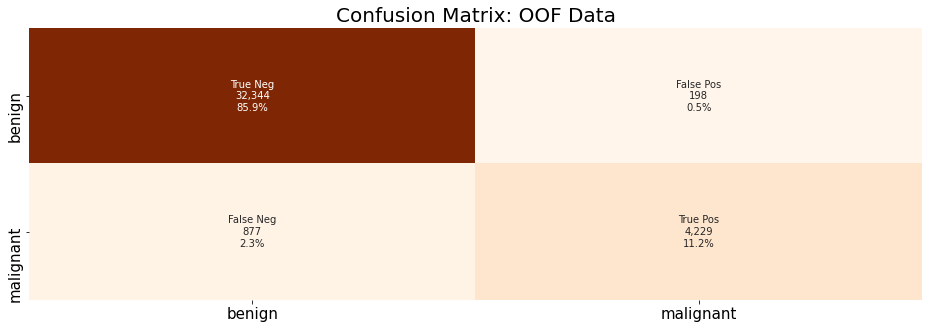

In [27]:
# Make OOF Binary
oof.loc[oof.oof >= 0.5, 'oof'] = 1
oof.loc[oof.oof < 0.5, 'oof'] = 0

# Create Confusion Matrix
cf_matrix = confusion_matrix(train_df['target'], oof)

# Pretty CM:
group_names = ['True Neg','False Pos','False Neg','True Pos']
# Format of the absolute numbers
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
# Format for relative numbers
group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# --- The figure ---
plt.figure(figsize=(16, 5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'], cbar=False)

matplotlib.rcParams.update({'font.size': 15})
plt.tick_params(axis='both', labelsize=15)
plt.title('Confusion Matrix: OOF Data', fontsize=20);

In [28]:
# Divide predictions by the number of folds
preds_submission /= k
preds_submission = preds_submission.cpu().numpy().reshape(-1,)

# Import submission file
ss = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

ss['target'] = preds_submission
ss.to_csv(f'submission_{version}.csv', index=False)

In [29]:
def best_single_model(model, preds_submission, TTA=3):
    '''Function that takes an input model (trained) and makes the prediction for submission.'''
    
    test = MelanomaDataset(test_df, vertical_flip=0.5, horizontal_flip=0.5,
                           is_train=False, is_valid=False, is_test=True)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers=8)
    
    model.eval()

    with torch.no_grad():
        for i in range(TTA):
            for k, (images, csv_data) in enumerate(test_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                # Covert to probablities
                out = torch.sigmoid(out)

                # ADDS! the prediction to the matrix we already created
                preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out


        # Divide Predictions by TTA (to average the results during TTA)
        preds_submission /= TTA
        
    return preds_submission